# Conductividad térmica registros de pozo
## Cálculo de la conductividad térmica as lo largo de los registros de pozo
#### Se procede a cargar los registros de pozo disponibles. A continuación, se propone una expresión que utiliza los registros de pozo como variables de entrada. Esta expresión se utiliza para modelar la conductividad térmica a lo largo de la profundidad del pozo en cuestión.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import welly
from welly import Project
import tensorflow as tf

In [3]:
proyecto = Project.from_las('/Users/Chemitas/Desktop/Desk/UNAM/ultimo_semestre/Solecita/IP_Procesamiento/*.las') # Carga los archivos .las
proyecto

6it [00:00,  6.40it/s]


Index,UWI,Data,Curves
0,H-43,12 curves,"KINT, PHIT, PIGN, RHGA, SUWI, VALB, VCL, VILL, VQUA, VUWA, VXBW, VXWA"
1,H-43,4 curves,"DTST, FWID_AHF, STRC:1, STRC:2"
2,H-43,6 curves,"DTCO, DTSM, DTST, PR, SPHI, VPVS"
3,H-43,6 curves,"DTCO, DTSM, DTST, PR, SPHI, VPVS"
4,H-43,18 curves,"BS, DPHIS, DPHIL, GR, HCAL, NPHI, PEFZ, RHOZ, RLA1, RLA2, RLA3, RLA4, RLA5, SP, TEMP, TENS, TNPHL, TNPHS"
5,H43-Roxan,27 curves,"FPG_CDR_RT, PGMW, WMUD:1, WMUD:2, BFAZ:1, BFAZ:2, TPSG, RHOB, PPGI, AZIM, PPRS, TYSP, TXSP, TZSP, PR:1, YME:1, BMK, SMG, TSTR, FANG, UCS, ALPH, PR:2, YME:2, PHIE, BS, WMUD:3"


In [4]:
gr = proyecto[4].data['GR']
temp = proyecto[4].data['TEMP']
dphis = proyecto[4].data['DPHIS']
R = proyecto[4].data['RLA5']

In [5]:
gr

Curve(mnemonic=GR, units=GAPI, start=1245.1080, stop=1636.0140, step=0.1524, count=[2566])

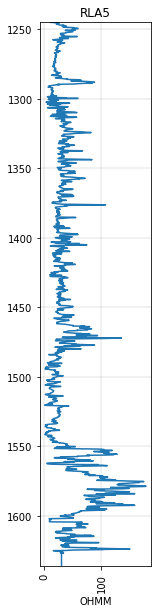

In [6]:
R.plot();

In [7]:
inicio = 1245.1080
fin = 1636.0140
depth = np.linspace(inicio, fin, len(gr.values))

In [8]:
vsh_linear = (gr - gr.min()) / (gr.max() - gr.min())
vsh_larinov = 1/3 * (2**(2*vsh_linear) - 1)
vsand_larinov = abs(vsh_larinov - 1)

In [9]:
ksh = 0.714
ksand = 0.25

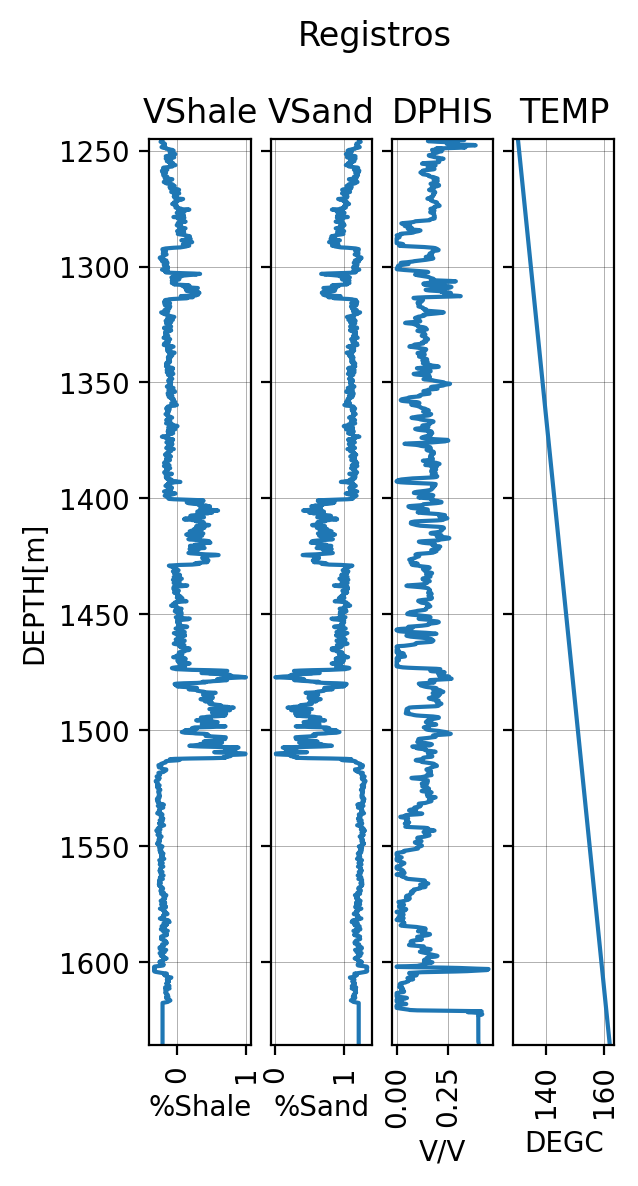

In [10]:
fig, ax = plt.subplots(1,4, figsize = (3,6), dpi = 200, sharey = True)
vsh_larinov.plot(ax[0])
ax[0].set_title('VShale')
ax[0].set_ylabel('DEPTH[m]')
ax[0].set_xlabel('%Shale')
vsand_larinov.plot(ax[1])
ax[1].set_title('VSand')
ax[1].set_xlabel('%Sand')
dphis.plot(ax[2])
temp.plot(ax[3])
plt.suptitle('Registros')
plt.savefig('registros.jpeg', bbox_inches = 'tight')

In [11]:
def calculate_thermal_conductivity(gr, temperature, dphis):

    K_sand = 5.0  
    K_clay = 1.7  


    vsh_linear = (gr - gr.min()) / (gr.max() - gr.min())
    vsh_larinov = 1/3 * (2**(2*vsh_linear) - 1)
    vsand_larinov = abs(vsh_larinov - 1)

    # Calcular la conductividad térmica del pozo
    Krock = ((vsand_larinov * K_sand) + (vsh_larinov * K_clay))


    return Krock

In [12]:
thermal_conductivity = calculate_thermal_conductivity(gr, temp, dphis)
print("Conductividad térmica estimada:", thermal_conductivity)

Conductividad térmica estimada: Curve(mnemonic=GR, units=GAPI, start=1245.1080, stop=1636.0140, step=0.1524, count=[2566])


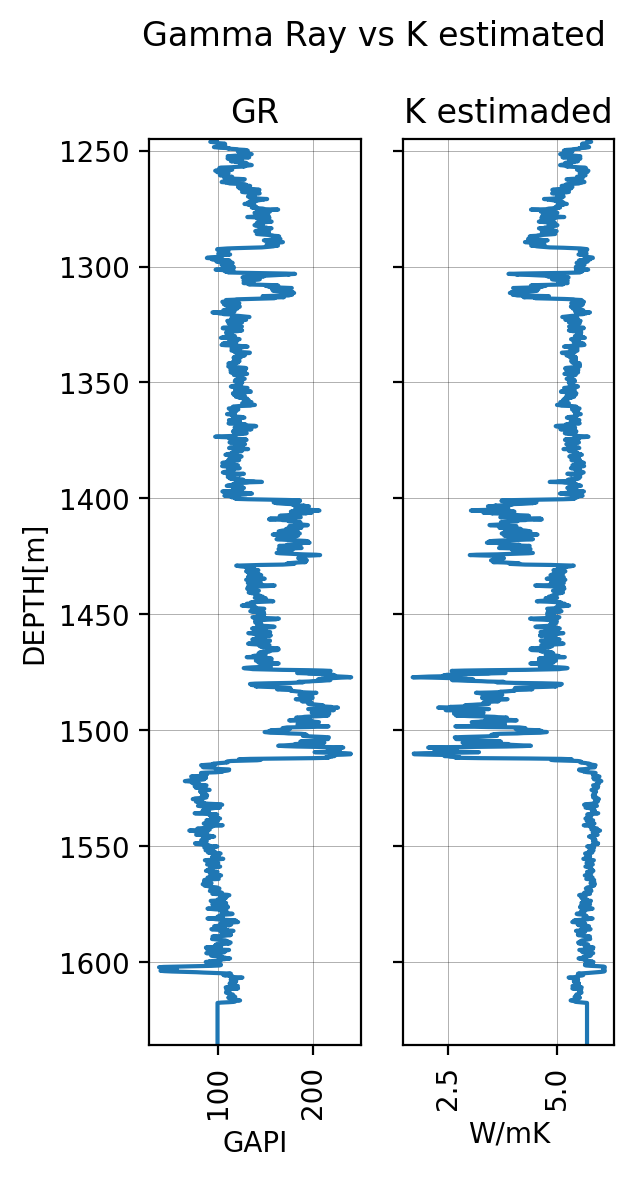

In [14]:
fig, ax = plt.subplots(1,2, figsize = (3,6), dpi = 200, sharey = True)
gr.plot(ax[0])
ax[0].set_ylabel('DEPTH[m]')
thermal_conductivity.plot(ax[1]);
ax[1].set_title('K estimaded')
ax[1].set_xlabel('W/mK')
plt.suptitle('Gamma Ray vs K estimated')
plt.savefig('kestimada.jpeg', bbox_inches = 'tight')

In [52]:
def medias(PHIE, GR, Ro):
    Rw1 = 0.0723 # lutitas
    Rw2 = 10 # arenas
    m1 = 3
    m2 = 2.4
    a1 = 0.999
    a2 = 1
    n = 2
    
    Sw = []
    for i in range(len(PHIE)):
        if PHIE.values[i] is not None:  # Verificar si el valor de PHIE no es nulo
            if GR.values[i] <= 150:
                Sw.append(np.power((a2 * Rw2) / (Ro.values[i] * PHIE.values[i]+0.001), m2/n))
            if GR.values[i] > 150:
                Sw.append(np.power((a1 * Rw1) / (Ro.values[i] * PHIE.values[i]+0.001), m1/n))
        
        
    perm = []
    for i in range(len(Sw)):
        if Sw[i] is not None:
            
            if GR.values[i] <= 150:
                perm.append(a2 * PHIE.values[i]**m2 * Sw[i]**n)
            if GR.values[i] > 150:
                perm.append(a1 * PHIE.values[i]**m1 * Sw[i]**n)
            
    perm = list(filter(lambda x: not math.isnan(x), perm))
    arim = sum(perm)/len(perm)
    log_perm = sum(math.log(x) for x in perm if x > 0)
    geom = log_perm / len(perm)
    harm = len(perm) / sum(1 / x for x in perm)

    print('-------------------------------------------')
    print('Permeabilidad promedio (aritmética):', arim)
    print('Permeabilidad promedio (geométrica):', geom)
    print('Permeabilidad promedio (armónico):', harm)
    print('-------------------------------------------')


    return arim

In [53]:
arim = medias(dphis, gr, R)

-------------------------------------------
Permeabilidad promedio (aritmética): 0.6925168528802225
Permeabilidad promedio (geométrica): -5.796670070993137
Permeabilidad promedio (armónico): 0.0
-------------------------------------------


<ipython-input-52-5af9ab8d830b>:32: RuntimeWarning: divide by zero encountered in double_scalars
  harm = len(perm) / sum(1 / x for x in perm)
